In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import os, glob
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = "aria|l"
import natsort
import warnings
warnings.filterwarnings('ignore')

In [2]:
# datadir_total = glob.glob(f'./odor_data_cropped/*/*.csv')
datadir_total = natsort.natsorted(glob.glob(f'./odor_data_cropped/*/*.csv'))
odorlist = ['Ethanol', 'Smoked','Mint'] # 향 리스트(파일이름)

# datadir_1 = [x for x in datadir_total if 'Nothing' in x]
# datadir_2 = [x for x in datadir_total if 'Ethanol' in x]
# datadir_3 = [x for x in datadir_total if 'LighterOil' in x]
# datadir_all = datadir_1 + datadir_2 + datadir_3

datadir_all = datadir_total

len(datadir_all)

9840

In [5]:
# # 학습/검증 데이터
# sensornum = 5
# class_list = []
# exp_list   = []
# Data = []

# for i in range(len(datadir_all)):
    
#     # 데이터 불러오기
#     tmp_name = datadir_all[i]
#     tmp_data = pd.read_csv(tmp_name)
#     tmp_data = tmp_data[['NH3', 'C2H4', 'H2', 'CH2O', 'VOC']]
#     print(tmp_name,'\n',np.mean(tmp_data))

In [23]:
# 학습/검증 데이터
sensornum = 7
class_list = []
exp_list   = []
Data = []

for i in range(len(datadir_all)):
    
    # 데이터 불러오기
    tmp_name = datadir_all[i]
    tmp_data = pd.read_csv(tmp_name)
    tmp_data = tmp_data[['NH3', 'C2H4', 'H2', 'CH2O', 'VOC','Humidity','Temperature']]
    
    # Raw Data Scaling
#     tmp_data['ETO'] = tmp_data['ETO'] / 255
    tmp_data['NH3'] = tmp_data['NH3'] / 255
    tmp_data['C2H4'] = tmp_data['C2H4'] / 255
    tmp_data['H2']  = tmp_data['H2'] / 255
#     tmp_data['CO2'] = tmp_data['CO2'] / 5000
    tmp_data['VOC'] = tmp_data['VOC'] / 3
    tmp_data['CH2O'] = tmp_data['CH2O'] / 2000
    tmp_data['Humidity'] = tmp_data['Humidity'] / 100
    tmp_data['Temperature'] = tmp_data['Temperature'] / 65
    
    tmp_data_arr = np.array(tmp_data)
    class_list.append(tmp_name.split('\\')[-1].split('_')[0]) # odor
    exp_list.append(int(tmp_name.split('\\')[-2].split('odor_data')[-1])) # exp. number
    Data.append(tmp_data_arr)
    
    if i % 100 == 0:
        print(i)
    
class_list_df = pd.Series(class_list)
exp_list_df   = pd.Series(exp_list)
Data = np.array(Data)
print(Data.shape, class_list_df.shape, exp_list_df.shape) 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
(9840, 100, 7) (9840,) (9840,)


In [27]:
# 레이블 값 바꾸기
class_sense = ['Good', 'Bad', 'Unsafe']
class_df = class_list_df.copy()

class_df.loc[class_df=='Mint']       = class_sense[0]
class_df.loc[class_df=='Orange']     = class_sense[0]
class_df.loc[class_df=='Nothing']    = class_sense[0]
class_df.loc[class_df=='Smoked']     = class_sense[1]
class_df.loc[class_df=='BBQ']        = class_sense[1]
class_df.loc[class_df=='Ethanol']    = class_sense[2]
class_df.loc[class_df=='LighterOil'] = class_sense[2]
class_df.loc[class_df=='Clorox']     = class_sense[2]
class_df

0       Unsafe
1       Unsafe
2       Unsafe
3       Unsafe
4       Unsafe
         ...  
9835       Bad
9836       Bad
9837       Bad
9838       Bad
9839       Bad
Length: 9840, dtype: object

In [28]:
class_df.value_counts()

Bad       4288
Good      2942
Unsafe    2610
dtype: int64

In [29]:
x_all = Data
y_all = pd.get_dummies(class_df)[class_sense]

# x_all = Data
# y_all = pd.get_dummies(class_list_df)[odorlist]

x_all.shape, y_all.shape

((9840, 100, 7), (9840, 3))

## Model Train - Cross validation

In [30]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [31]:
def CNN_model(input_data, lyrnum=4, ftnum=8, ksize=8):
    keras.backend.clear_session() # 세션 지우기
    tf.keras.utils.set_random_seed(777)
    
    inputs = keras.Input(shape=(input_data.shape[1], input_data.shape[2]), name = 'input')
    x = keras.layers.Conv1D(filters = ftnum, kernel_size=ksize, strides=1, padding='same',
                                activation='relu',name = 'conv0')(inputs)
    for lyr in range(1, lyrnum):
        x = keras.layers.Conv1D(filters = ftnum, kernel_size=ksize, strides=1, padding='same',
                                activation='relu',name = f'conv{lyr}_1')(x)
        x = keras.layers.Conv1D(filters = ftnum, kernel_size=ksize, strides=2, padding='same',
                                activation='relu',name = f'conv{lyr}_2')(x) # dowmsampling layer
        
    
#     x = keras.layers.GlobalAveragePooling1D(name='GAP')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units = 16, activation='relu', name='dense1')(x)
#     x = keras.layers.Dense(units = 32, activation='relu', name='dense2')(x)
    
    outputs = keras.layers.Dense(units = len(class_sense), activation='softmax', name='output')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name=f'{lyrnum}layers_{ftnum}filters_{ksize}ks')
    model.compile(optimizer= keras.optimizers.Nadam(learning_rate = 0.0005),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model


EpochForPrintAcc = 20
class AccuracyPerEpoch(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keras.callbacks.Callback()
        if epoch%EpochForPrintAcc == 0:
            print("{} Epochs Accuracy : train {:.2f}%, valid {:.2f}% ".format(epoch, logs["accuracy"]*100, logs["val_accuracy"]*100))
            
# 콜백함수: 조기종료
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto', restore_best_weights=True)

# 콜백함수: learning rate 업데이트
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=10, verbose=0, mode="auto", cooldown=0, min_lr=0.000005)

odor data number: 1
train:  9338 ,   test:  502
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                               

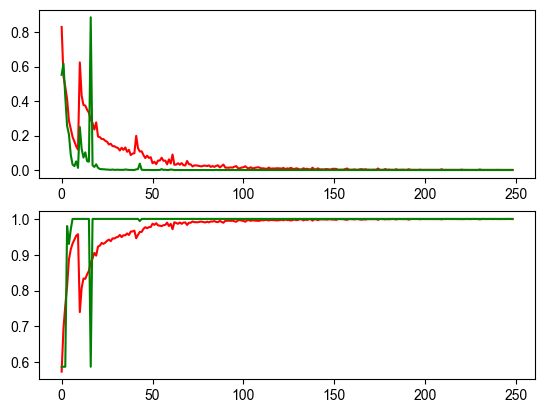

odor data number: 2
train:  9383 ,   test:  457
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                               

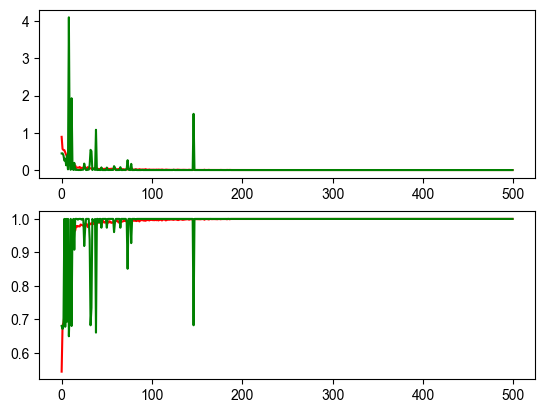

odor data number: 3
train:  9396 ,   test:  444
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                               

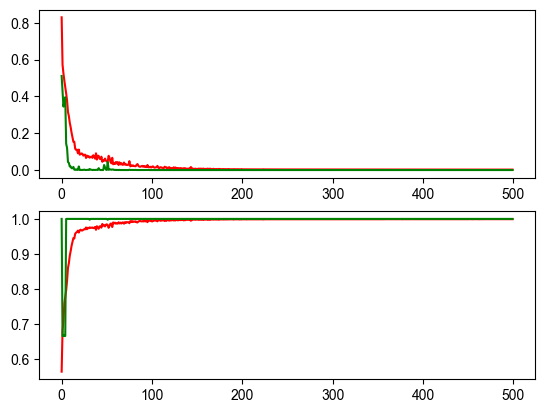

odor data number: 4
train:  9365 ,   test:  475
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                               

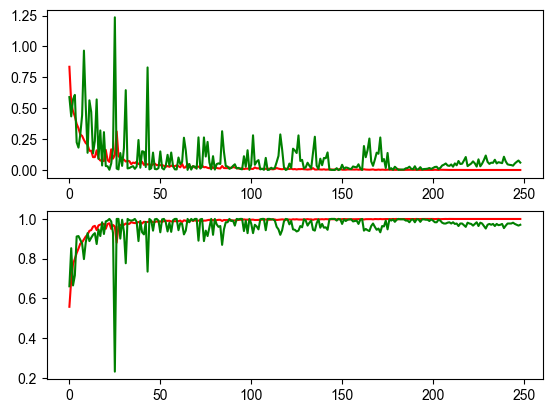

odor data number: 5
train:  9397 ,   test:  443
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                               

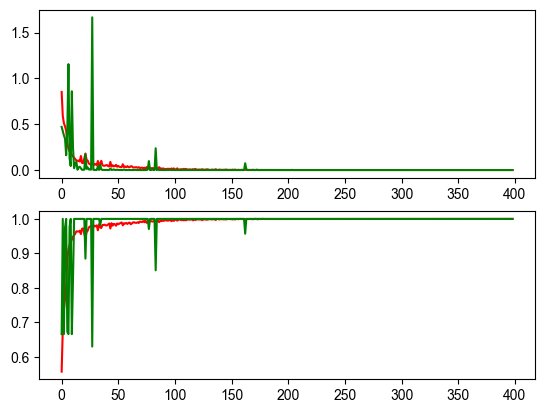

odor data number: 6
train:  9399 ,   test:  441
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                               

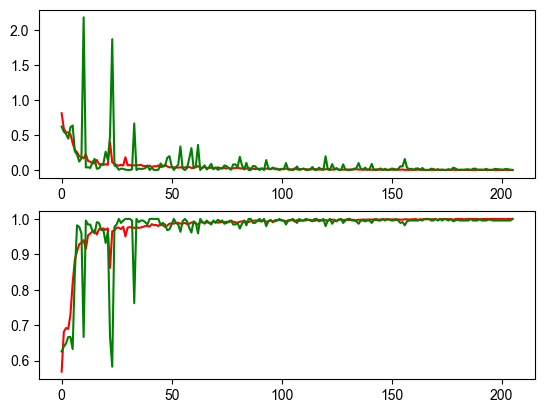

odor data number: 7
train:  8889 ,   test:  951
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                               

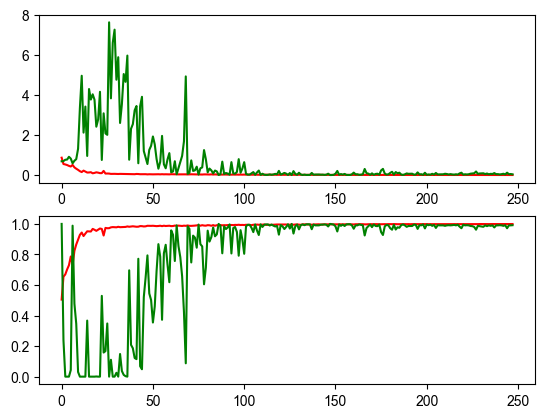

odor data number: 8
train:  8559 ,   test:  1281
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                              

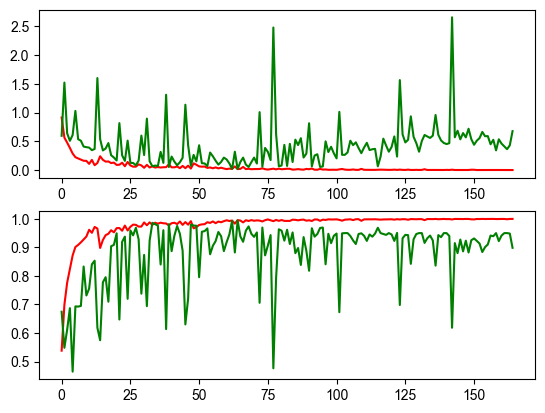

odor data number: 9
train:  8267 ,   test:  1573
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                              

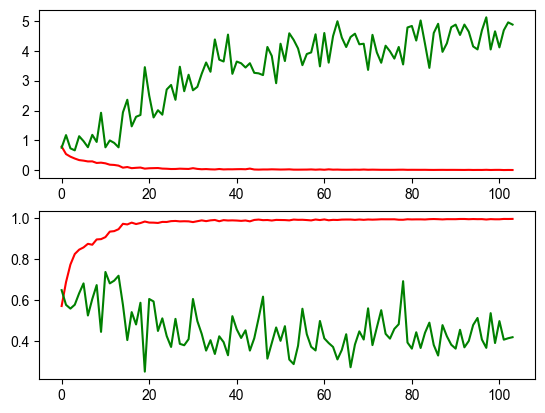

odor data number: 10
train:  8695 ,   test:  1145
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                             

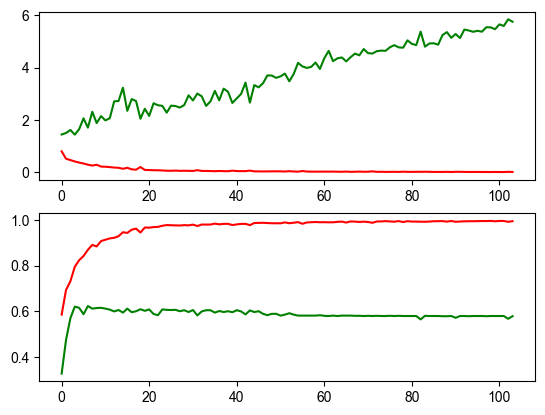

odor data number: 11
train:  8889 ,   test:  951
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                              

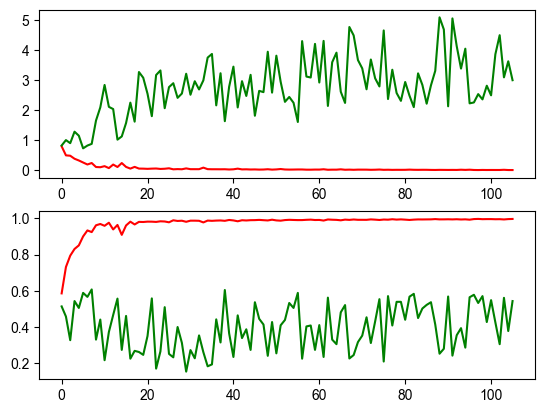

odor data number: 12
train:  8663 ,   test:  1177
Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                             

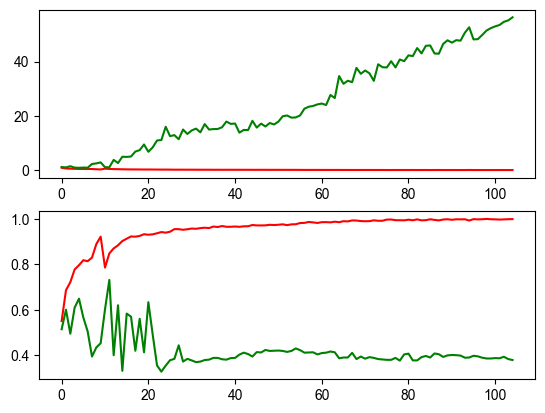

In [34]:
# 학습 설정
explist  = list(range(1,12+1))

# 모델 하이퍼파라미터
Epoch = 500 # 최대 Epoch
lyrnum   = 4          # Conv 레이어 수
ftnum    = 8          # Conv 레이어 필터수
ksize    = 14          # kernel size

# 기록용 변수
Accuracy_df = pd.DataFrame(np.zeros(shape=(len(explist),2)),
                           columns=['Test data No.', 'Test Accuracy'])
cnt=0

for exp in explist:
    print(f'odor data number: {exp}')
    x_train = x_all[exp_list_df!=exp]
    x_test  = x_all[exp_list_df==exp]
    y_train = y_all[exp_list_df!=exp]
    y_test  = y_all[exp_list_df==exp]
    
    print('train: ', len(y_train), ',   test: ', len(y_test))
    
    # 생성/구조확인
    model = CNN_model(x_train, lyrnum, ftnum, ksize)
    print(model.summary())
    # 학습
    Hist = model.fit(x_train, y_train, epochs=Epoch, validation_data=(x_test, y_test), verbose=0,
                     callbacks=[earlyStopping, reduce_lr, AccuracyPerEpoch()] )
    
    # 검증정확도
    TestLoss, TestScore = model.evaluate(x_test, y_test, verbose=0)
    # 저장
    model.save(f'./CNNmodel_cv/exp{exp}test_model.h5')
    pd.DataFrame(Hist.history).to_csv(f'./CNNmodel_cv/exp{exp}test_model hist.csv')
    
    
    Accuracy_df.iloc[cnt, :] = [exp, TestScore] # 모델 시험정확도 기록
    
    fig, ax = plt.subplots(2,1)
    ax[0].plot(Hist.history['loss'], c='r');     ax[0].plot(Hist.history['val_loss'], c='g')
    ax[1].plot(Hist.history['accuracy'], c='r'); ax[1].plot(Hist.history['val_accuracy'], c='g')
    plt.show()
    cnt += 1
    del model
    del Hist
Accuracy_df.to_csv('./CNNmodel_cv/CVresult.csv')

## Model Test

In [83]:
# x_all = Data
# y_all = pd.get_dummies(class_df)[class_sense]

# x_all = Data
# y_all = pd.get_dummies(class_list_df)[odorlist]

## 공인인증평가용

# x_test  = np.array(x_all)
# y_test  = np.array(y_all)

# x_all.shape, y_all.shape

((540, 100, 5), (540, 3))

In [35]:
# 실험 회차
testno=9

x_test  = np.array(x_all[exp_list_df==testno])
y_test  = np.array(y_all[exp_list_df==testno])

model = keras.models.load_model(f'./CNNmodel_cv/exp{testno}test_model.h5')
model.summary()

Model: "4layers_8filters_14ks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 conv0 (Conv1D)              (None, 100, 8)            792       
                                                                 
 conv1_1 (Conv1D)            (None, 100, 8)            904       
                                                                 
 conv1_2 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_1 (Conv1D)            (None, 50, 8)             904       
                                                                 
 conv2_2 (Conv1D)            (None, 25, 8)             904       
                                                                 
 conv3_1 (Conv1D)            (None, 25, 8)   

In [36]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(acc)

0.5759694576263428


In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

prediction = np.array(model(x_test))

#get max index and make array
y_true = np.argmax(y_test,     axis=-1)
y_pred = np.argmax(prediction, axis=-1)

y_true.shape, y_pred.shape

((1573,), (1573,))

In [38]:
correct_indices = np.where(y_true == y_pred)

incorrect_indices = np.where(y_true != y_pred)
incorrect_indices

(array([ 389,  390,  391,  392,  393,  394,  395,  396,  397,  398,  399,
         400,  401,  402,  403,  404,  405,  406,  407,  408,  409,  410,
         411,  412,  413,  414,  415,  416,  417,  418,  419,  420,  421,
         422,  423,  424,  425,  426,  427,  428,  429,  430,  431,  432,
         433,  434,  435,  436,  437,  438,  439,  440,  441,  442,  443,
         444,  445,  446,  447,  448,  449,  450,  451,  452,  453,  454,
         455,  456,  457,  458,  459,  460,  461,  462,  463,  464,  465,
         466,  467,  468,  469,  470,  471,  472,  473,  474,  475,  476,
         477,  478,  479,  480,  481,  482,  483,  484,  485,  486,  487,
         488,  489,  490,  491,  492,  493,  494,  495,  496,  497,  498,
         499,  500,  501,  502,  503,  504,  505,  506,  507,  508,  509,
         510,  511,  512,  513,  514,  515,  516,  517,  518,  519,  520,
         521,  522,  523,  524,  525,  526,  527,  528,  529,  530,  531,
         532,  533,  534,  535,  536, 

In [69]:
tmp_y_test = np.zeros((889,3))
tmp_y_test[:,[1,2]]=y_test
y_test = tmp_y_test

In [41]:
correct_path = [datadir_total[500:][s] for s in correct_indices[0]]
correct_path

['./odor_data_cropped\\odor_data2\\Ethanol_0.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_1.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_10.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_100.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_101.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_102.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_103.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_104.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_105.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_106.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_107.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_108.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_109.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_11.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_110.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_111.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_112.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_113.csv',
 './odor_data_cropped\\odor_data2\\Ethanol_114.csv',

In [44]:
import shutil
import os

for path in correct_path:
    dst = (path.replace("data2","data7"))
    shutil.copy(path, dst)

In [70]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(acc)

1.0


In [12]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(acc)

0.693989098072052


In [ ]:
# counting
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

In [ ]:
#make  it into confusion matrix
cm = confusion_matrix(y_pred, y_true)

#for labeling
x = class_sense
y = class_sense

# create Dataframe
df = pd.DataFrame(cm,columns=y, index=x)

# heatmap
fig, ax = plt.subplots(figsize=(10,8))    # figsize
sns.set(font_scale=1)

# ax = sns.heatmap(df/np.sum(df),
#                  cmap='Blues',           # cmap Color
#                  annot=True,            # Value Text
#                  fmt=".1%",             # Value type (interge = "d")
#                  linewidths=2)

ax = sns.heatmap(df,
                 cmap='Blues',           # cmap Color
                 annot=True,            # Value Text
                 fmt="d",             # Value type (interge = "d")
                 linewidths=2)

plt.xlabel('True', fontsize=15)
plt.ylabel('Pred', fontsize=15)
plt.title(f'Exp #{testno} test confusion matrix', fontsize=20)
plt.show()

In [ ]:
x_train = np.array(x_all[exp_list_df!=testno])
y_train = np.array(y_all[exp_list_df!=testno])

prediction = np.array(model(x_train))

#get max index and make array
y_true = np.argmax(y_train,    axis=-1)
y_pred = np.argmax(prediction, axis=-1)

loss, acc = model.evaluate(x_train, y_train, verbose=0)
print(acc)

#make  it into confusion matrix
cm = confusion_matrix(y_pred, y_true)

#for labeling
x = class_sense
y = class_sense

# create Dataframe
df = pd.DataFrame(cm,columns=y, index=x)

# heatmap
fig, ax = plt.subplots(figsize=(10,8))    # figsize
sns.set(font_scale=1)

# ax = sns.heatmap(df/np.sum(df),
#                  cmap='Blues',           # cmap Color
#                  annot=True,            # Value Text
#                  fmt=".1%",             # Value type (interge = "d")
#                  linewidths=2)

ax = sns.heatmap(df,
                 cmap='Blues',           # cmap Color
                 annot=True,            # Value Text
                 fmt="d",             # Value type (interge = "d")
                 linewidths=2)

plt.title(f'Exp #{testno} train confusion matrix', fontsize=20)
plt.xlabel('True', fontsize=15)
plt.ylabel('Pred', fontsize=15)
plt.show()

### Flatten layer 시각화

In [ ]:
newmodel = keras.models.Model(inputs=model.input, outputs=model.get_layer('flatten').output)
newmodel.summary()

In [ ]:
x_train_flt = np.array(newmodel(x_train))
x_test_flt = np.array(newmodel(x_test))

x_train_flt.shape, x_test_flt.shape

In [ ]:
from sklearn.decomposition import PCA

# 10개 PC(Principal Component) 추출
pca = PCA(n_components = 10)
PC_train  = pca.fit_transform(x_train_flt)
PC_test   = pca.transform(x_test_flt)

In [ ]:
colors1 = [
    (0.3, 0.7, 0.8, 0.1),
    (1.0, 0.6, 0.3, 0.1),
    (0.0, 0.4, 0.8, 0.1)
]
colors2 = [
    (0.3, 0.7, 0.8, 0.9),
    (1.0, 0.6, 0.3, 0.9),
    (0.0, 0.4, 0.8, 0.9)
]

In [ ]:
plt.figure(1, (8, 8))

for i, odor in enumerate(class_sense):
    
    PC_train_odor = PC_train[y_train[:,i]==1]
    PC_test_odor  = PC_test[y_test[:,i]==1]

    plt.plot(PC_train_odor[:,0],PC_train_odor[:,1],linestyle='', marker ='o', markersize = 7, label = f'{odor}_TrainData', c=colors1[i],
             markeredgecolor=[0,0,0,0.7], markeredgewidth=0.4)
    plt.plot(PC_test_odor[:,0],PC_test_odor[:,1],linestyle='', marker ='o', markersize = 7, label = f'{odor}_TestData', c=colors2[i],
             markeredgecolor=[0,0,0,0.7], markeredgewidth=0.4)
    
plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.7))
plt.xlabel('PC1'); plt.ylabel('PC2'); 
plt.title('odor data IDCNN Flattened PCA')
plt.grid()
plt.show()